In [11]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import sleep
from IPython import display
from utils import plot_decision_boundary
from sklearn.base import BaseEstimator

# Feedforward neural networks

![nn](nn.png)

**Reference**  http://www.rsipvision.com/exploring-deep-learning/

With neural networks, units are organized in layers, you can think of each **layer** as a representation of the inputs, just like we did with polynomials, except that these representations are learned from data. 

In this view, the **input layer** and the **output layer** are no longer special layers, but also representations of the same data.

- The **input layer** are the raw representation of the data
- The **output layer** can also be seen as a representation of the same data, except that it is a very abstract representation (for instance, class labels)
- **Hidden layers** are representations of intermediate levels of abstraction going from less abstract to more abstract as we go from the input layer to the output layer.

In feedforward neural networks, each layer is a linear transformation of the previous layer for which we apply a non-linear function called the **activation function**. Or put it in another way, each unit of each layer is a linear combination of all the units of the previous layer for which we apply a non-linear function called the **activation function**.

A feedforward neural network can thus be easily expressed using products of matrices, for instance let's say we have 2 hidden layers.

let's say $x$ is an input vector:

- $h_1 = g^{(1)}(W^{(1)}x + b^{(1)})$ is the first hidden layer
- $h_2 = g^{(2)}(W^{(2)} h_1 + b^{(2)})$ is the second hidden layer
- $y = g^{(3)}(W^{(3)}h_2 + b^{(3)})$ is the output layer

where:

- $g^{(l)}$ is the activation function of the layer l
- $W^{(l)}$ are called the weights and they determine the linear transformation we use from one layer to another

Let's build a simple example :

In [26]:
W1 = np.random.uniform(0, 1, size=(X.shape[1], 100)) # 100 units in the first layer
W2 = np.random.uniform(0, 1, size=(100, 50)) # 50 units in the second layer
W3 = np.random.uniform(0, 1, size=(50, 1)) # 1 unit in the output layer

b1= np.random.uniform(0, 1, size=(100,))
b2 = np.random.uniform(0, 1, size=(50))
b3 = np.random.uniform(0, 1, size=(1,))

g = np.tanh # the activation function is the same for all the layers

h1 = g(np.dot(X, W1) + b1)
h2 = g(np.dot(h1, W2) + b2)
y = g(np.dot(h2, W3) + b3)

print(X.shape, h1.shape, h2.shape, y.shape)

((500, 2), (500, 100), (500, 50), (500, 1))


### Loss function

Given a **task** and a **dataset**, for instance class prediction of insects, how do we train a neural network ?

First, we specify what we want from the model through the **loss function**, also known as **objective function**.
Usually it describes the difference between what what we predict and the "truth" and we want thus to minimize the **loss function**.

For class prediction, the loss function could be the number of misclassifications on the training data.
The problem with this loss function is that it is not smooth, and neural networks need smooth loss functions
to be trained. We rather employ surrogates of the misclassification loss function and monitor the
real loss function we want to minimize in training/valid/test data.

For binary classification, the simplest loss function we can use is the mean squared error :

$$L(X, y) = \frac{1}{2N}\sum_{i=1}^N (f(X_i) - y_i)^2$$

where f is a function that computes the output of the neural network

  ## Backpropagation

Having the dataset and having defined the loss function, how do we 
actually train the weights of the neural network ?

The usual algorithm for training neural networks is gradient descent (and its variants), which requires
us to compute the derivatives of the loss function with respect to the parameters of the neural network, which
are the weights and the biases.

**Backpropagation** is an algorithm for computing the partial derivatives  of the loss function with respect
to the parameters of any network defined by a Directed Acyclic Graph (DAG), it is basically
a recursive application of the chain rule starting from the outputs and going backwards through
the edges of the graph.

![bp](backprop.png)

Let's take a simple example. the above graph is a computation graph, each node is a function
of its predecessors, the direction is the way we procede to compute the outputs, so
we start at **r** and **t**, compute **x** based on **r** and **t**, compute **y** based on **r** and **t** then finally
compute **u** based on **x** and **y**.

The chain rule for partial derivatives tells us that :

$$\frac{\partial u}{\partial r} = \frac{\partial u}{\partial x}\frac{\partial x}{\partial r} + \frac{\partial u}{\partial y}\frac{\partial y}{\partial r}$$

and

$$\frac{\partial u}{\partial t} = \frac{\partial u}{\partial x}\frac{\partial x}{\partial t} + \frac{\partial u}{\partial y}\frac{\partial y}{\partial t}$$

and

we have the expressions of $$\frac{\partial u}{\partial x}$$ and
$$\frac{\partial u}{\partial y}$$  because they are direct predecessors of **u**.


Now suppose the node **u** is representing the loss function and the dependency between nodes is parametrized each one by 
a parameter:

![bp](backprop2.png)


then as seen above backprop gives us a way to compute the partial derivative of the loss function with respect to any node,
for instance for **r** : $\frac{\partial u}{\partial r}$, based on the partial derivatives of the loss function with respect to its successors,
for **r** it is **x** and **y**, thus $\frac{\partial u}{\partial x}$ and $\frac{\partial u}{\partial y}$.

So partial derivatives of the loss function **u** with respect to the nodes **x, y, r, t** are computed like the following, first we compute $\frac{\partial u}{\partial x}$  and $\frac{\partial u}{\partial y}$ directly because they are direct predecessors of **u**, then we go backward into the predecessors of **x** and **y** and compute $\frac{\partial u}{\partial r}$ and $\frac{\partial t}{\partial y}$ based on $\frac{\partial u}{\partial x}$ and $\frac{\partial u}{\partial y}$. This procedure (backpropagation) is generalizable to any Direct Acyclic Graph (DAG).

Now, having computed the partial derivative of the loss function with respect to the all the nodes with backpropagation, the derivatives of the loss function with respect to the parameters is easily obtained :


$$\frac{\partial u}{\partial W_{rx}} =\frac{\partial u}{\partial x}\frac{\partial x}{\partial W_{rx}}$$
$$\frac{\partial u}{\partial W_{ry}} =\frac{\partial u}{\partial y}\frac{\partial y}{\partial W_{ry}}$$


$$\frac{\partial u}{\partial W_{tx}} =\frac{\partial u}{\partial x}\frac{\partial x}{\partial W_{tx}}$$
$$\frac{\partial u}{\partial W_{ty}} =\frac{\partial u}{\partial y}\frac{\partial y}{\partial W_{ty}}$$


Now let's see what backpropagation gives for feedforward neural networks.

We consider a neural network with **L** layers and we illustrate below two intermediate layers **l** and **l+1** and compute the partial derivatives of one layer given the partial derivatives of the next layer using backpropagation as given above.

![backprop-nnet.png](backprop-nnet.png)

the above computational graph translates into:

$$E^{(l+1)}_j = \sum_i H^{(l)}_i W^{(l)}_{i, j}$$

and

$$H^{(l+1)}_j = g^{(l+1)}(E^{(l+1)}_j)$$

where $g^{(l)}$ is the activation function of the layer **l + 1**.

The vectorized version is:

$$E^{(l+1)} = H^{(l)}W^{(l)}$$

and

$$H^{(l+1)} = g^{(l+1)}(E^{(l+1)})$$

Now, if **L** is the loss function node, then:

$$\frac{\partial L}{\partial H^{(l)}_i} = \sum_j \frac{\partial L}{\partial E^{(l+1)}_j} W^{(l)}_{i,j}$$

and

$$\frac{\partial L}{\partial E^{(l+1)}_j} = \frac{\partial L}{H^{(l+1)}_j}g'( E^{(l+1)}_j)$$

and the vectorized version is:

$\frac{\partial L}{\partial H^{(l)}} = \frac{\partial L}{\partial E^{(l+1)}}(W^{(l)})^T$ **(1)**

$\frac{\partial L}{\partial E^{(l+1)}} = \frac{\partial L}{\partial H^{(l+1)}} * g'( E^{(l+1)})$ **(2)**

the two above equations can be merged :

$$\frac{\partial L}{\partial H^{(l)}} = \frac{\partial L}{\partial H^{(l+1)}}g'( E^{(l+1)})(W^{(l)})^T$$

now to find the derivatives of the loss with respect to $W^{(l)}$, it is simple:

$$\frac{\partial L}{\partial W^{(l)}_{i, j}} = \frac{\partial L}{\partial E^{(l + 1)}_j}\frac{\partial E^{(l + 1)}_j}{\partial W_{i, j}} = \frac{\partial L}{\partial E^{(l + 1)}_j}H^{(l)}_i$$

and the vectorized form is:

$\frac{\partial L}{\partial W^{(l)}} = (H^{(l)})^T\frac{\partial L}{\partial E^{(l + 1)}}  $ **(3)**


Now we can use directly equations **(1)**, **(2)** and **(3)** to train a neural network, having defined the loss function.

Let's use equations **(1)**, **(2)** and **(3)** to train a basic neural network with 2 layers.

We will solve the same problem than before, so it is a classification problem and we will use the squared error as a loss function.

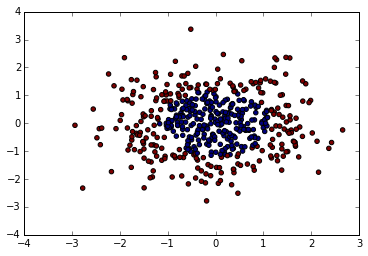

In [27]:
from sklearn.datasets import make_gaussian_quantiles
X, y = make_gaussian_quantiles(n_samples=500, n_features=2, n_classes=2)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)
plt.show()

In [28]:
print(y)

[0 1 0 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1
 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 0 1
 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 1 1
 1 0 1 0 0 0 1 1 0 1 1 1 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0
 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1 0 0
 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 0 0 0 0 1 1 1
 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1
 0 1 0 0 0 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 0
 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0
 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 0 1 1
 1 1 1 1 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 0 1 1 1 0 1 0 1 0 1 1 0 0 0 0 1 1 1
 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 1
 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 1
 1 1 0 0 1 1 0 1 0 1 1 1 

So we see that y is a binary variable, one way to predict values between 0 and 1 is to use the sigmoid  function $\sigma$ as an activation function on the output layer, like with logisitic regression.

Recall that : where $ \sigma(a) = \frac{1}{1 + exp(-a)}$


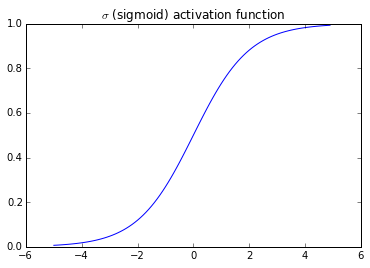

In [29]:
a = np.arange(-5, 5, 0.1)
plt.plot(a, 1./(1 + np.exp(-a)))
plt.title("$\sigma$ (sigmoid) activation function")

We use the squared error as a loss function, defined by :
    
$$L(X, y) = \frac{1}{2}\sum_{i=1}^N (f(X_i) - y_i)^2$$


The direct predecessors of the loss function node are the values of the output layer, so we first compute the derivatives of the loss function with respect to the output layer.
Assuming $O$ is the output layer,

$$\frac{\partial{L}}{\partial O} = (O - Y)$$

where $Y$ is the dataset "true" classes and $O$ the predicted ones, both are vectors
of size $N$, each element representing one example.

Then the derivation for the other layers is obtained directly using equations **(1)**, **(2)** and the derivation for the parameters from equation **(3)**. In equation **(3)** we did not include the derivatives for of the loss function with respect to the biases $b^{(l)}$, but it is straightforward and can be implied from equation **(3)**. You can think of the biases as part of the weights but multiplying inputs with the value of **1**, thus for biases,

$$\frac{\partial L}{\partial b_j^{(l)}} = \frac{\partial L}{\partial E^{(l + 1)}_j}\frac{\partial E^{(l + 1)}_j}{\partial b_j^{(l)}} = \frac{\partial L}{\partial E^{(l + 1)}_j}$$

and the vectorized form :

$$\frac{\partial L}{\partial b^{(l)}} = \frac{\partial L}{\partial E^{(l + 1)}}  $$




Our neural network is defined like this again:

- $h_1 = g^{(1)}(W^{(1)}x + b^{(1)})$ is the first hidden layer
- $h_2 = g^{(2)}(W^{(2)} h_1 + b^{(2)})$ is the second hidden layer
- $y = g^{(3)}(W^{(3)}h_2 + b^{(3)})$ is the output layer

where

$$g^{(1)}(a) = g^{(2)}(a) = g^{(3)}(a) = \sigma(a) =  \frac{1}{1 + exp(-a)}$$

For now we initialize the parameters randomly, we will talk more about initialization and its importance later. 

In [30]:
W1 = np.random.uniform(-0.001, 0.001, size=(X.shape[1], 100)) # 100 units in the first layer
W2 = np.random.uniform(-0.01, 0.01, size=(100, 50)) # 50 units in the second layer
W3 = np.random.uniform(-0.1, 0.1, size=(50, 1)) # 1 unit in the output layer

b1= np.zeros(100,)
b2 = np.zeros((50))
b3 = np.zeros((1,))

g = lambda x:1./(1 + np.exp(-x)) # the activation function is the same for all the layers

In [31]:
# let's try a forward pass and check the initial value of the loss function
N = y.shape[0]
e1 = np.dot(X, W1) + b1
h1 = g(e1)
e2 = np.dot(h1, W2) + b2
h2 = g(e2)
e3 = np.dot(h2, W3) + b3
o = g(e3)

print("X:{0}, h1:{1}, h2:{2}, y:{3}".format(X.shape, h1.shape, h2.shape, y.shape))

# initial accuracy
acc =  ((o>0.5)==y).mean()
print("accuracy : {0}".format(acc))
# initial loss function value
L = (0.5 * ((y[:, np.newaxis] - o)**2)).sum()
print("loss : {0}".format(L))

X:(500, 2), h1:(500, 100), h2:(500, 50), y:(500,)
accuracy : 0.5
loss : 63.4276362327


Let's apply backpropagation to get the derivatives of the loss with respect to the nodes

notice that for sigmoid, $$g'(a) = g(a) * (1 - g(a))$$

In [32]:
d_o = (o - y[:, np.newaxis] )
d_e3 = d_o * o * (1 - o) # equation 2 + using the property of the sigmoid described just above
d_h2 = np.dot(d_e3, W3.T) # equation 1
d_e2 = d_h2 * h2 * (1 - h2) # equation 2 + + using the property of the sigmoid described just above
d_h1 = np.dot(d_e2, W2.T) # equation 1
d_e1 = d_h1 * h1 * (1 - h1)

Now let's compute the derivatives with respect to the parameters using equation **3**

In [33]:
d_W3 = np.dot(h2.T, d_e3)
d_W2 = np.dot(h1.T, d_e2)
d_W1 = np.dot(X.T, d_e1)

d_b3 = d_e3.sum(axis=0)
d_b2 = d_e2.sum(axis=0)
d_b1 = d_e1.sum(axis=0)

In [ ]:
# gradient check

# Make sure the gradients are correct, use finite differences to compute
# gradients numeriacally and compare it to the gradients obtained by
# backpropgation

def get_loss(X):
    e1 = np.dot(X, W1) + b1
    h1 = g(e1)
    e2 = np.dot(h1, W2) + b2
    h2 = g(e2)
    e3 = np.dot(h2, W3) + b3
    o = g(e3)
    L = 0.5 * ((y[:, np.newaxis] - o)**2)
    return L.sum()

params = [W1, W2, W3, b1, b2, b3]
d_params = [d_W1, d_W2, d_W3, d_b1, d_b2, d_b3]
epsilon = 1e-6
for p, d_p in zip(params, d_params):
    p_flat = p.reshape((-1,))
    d_p_flat = d_p.reshape((-1,))
    for i in range(p_flat.shape[0]):
        # use finite difference to compute gradients numerically
        # and compare it with gradients computed from backprop
        val = p_flat[i]
        p_flat[i] = val + epsilon
        La = get_loss(X)
        p_flat[i] = val -  epsilon
        Lb = get_loss(X)
        p_flat[i] = val
        grad = (La - Lb) / (2 * epsilon)
        assert np.abs(grad - d_p_flat[i]) <= 1e-5

Gradient descent tells us that to minimize the loss function **L** with respect to some parameters $\Theta$ , we have to follow in each iteration the direction  defined by the **gradients** : -$\frac{\partial{L}}{\partial{\Theta}}$ scaled by a hyper-parameter $\alpha$ which defines the step size at each iteration and is called the **learning rate**.


Gradient descent can only converge to a local minimum. If the **learning rate** is too small, convergence towards the minimum is slow, but if the **learning rate** is too big, there is a risk that gradient descent diverges, so one seeks for the biggest value of the **learning rate** that do not diverge. Neural networks are very sensitive to the value **learning rate**, so it is important to tune it well.

With **batch gradient descent**, we add up the **gradients** of the loss with respect to the parameters for the whole training set, it is very inefficient for large datasets. For large datasets, it is rather **stochastic gradient descent** which is used, where for its "classical" version we take randomly one example in each epoch and perform one update of the parameters based on it. **mini-batch gradient descent** is in between, instead of taking one example at a time, we take a **mini-batch** of examples (e.g 100).

Let's do one step of gradient descent:

In [34]:
alpha = 0.001

In [35]:
W3 -= alpha * d_W3
W2 -= alpha * d_W2
W1 -= alpha * d_W1
b3 -= alpha * d_b3
b2 -= alpha * d_b2
b1 -= alpha * d_b1

and recompute the loss function value:

In [36]:
N = y.shape[0]
e1 = np.dot(X, W1) + b1
h1 = g(e1)
e2 = np.dot(h1, W2) + b2
h2 = g(e2)
e3 = np.dot(h2, W3) + b3
o = g(e3)

L = 0.5 * ((y[:, np.newaxis] - o)**2)
print("loss : ", L.sum())

('loss : ', 62.811671824013494)


Let's now put everything together and apply gradient descent for several iterations:

In [37]:
alpha = 0.04
nb_epochs = 2000

# Initialization
nb_hidden1 = 10
nb_hidden2 = 10

W1 = np.random.uniform(-0.0001, 0.0001, size=(X.shape[1], nb_hidden1))
W2 = np.random.uniform(-0.001, 0.001, size=(nb_hidden1, nb_hidden2)) # 50 units in the second layer
W3 = np.random.uniform(-0.01, 0.01, size=(nb_hidden2, 1)) # 1 unit in the output layer

b1= np.zeros(nb_hidden1,)
b2 = np.zeros((nb_hidden2))
b3 = np.zeros((1,))

g = lambda x:1./(1 + np.exp(-x)) # the activation function is the same for all the layers

('accuracy : ', 0.5)
('loss : ', 62.500183830127334)
('accuracy : ', 0.5)
('loss : ', 62.502094573510334)
('accuracy : ', 0.5)
('loss : ', 62.523857718802049)
('accuracy : ', 0.5)
('loss : ', 62.770713261877148)
('accuracy : ', 0.5)
('loss : ', 65.444175705570601)
('accuracy : ', 0.5)
('loss : ', 84.153086635654333)
('accuracy : ', 0.5)
('loss : ', 95.138787784432765)
('accuracy : ', 0.5)
('loss : ', 70.297266719589544)
('accuracy : ', 0.5)
('loss : ', 81.446797296616268)
('accuracy : ', 0.5)
('loss : ', 77.328972395659548)
('accuracy : ', 0.5)
('loss : ', 74.334962601142763)
('accuracy : ', 0.5)
('loss : ', 71.72581420395629)
('accuracy : ', 0.5)
('loss : ', 69.624368396220632)
('accuracy : ', 0.5)
('loss : ', 68.035701507824072)
('accuracy : ', 0.5)
('loss : ', 66.791065551780576)
('accuracy : ', 0.5)
('loss : ', 65.847623896143332)
('accuracy : ', 0.5)
('loss : ', 65.111724431150961)
('accuracy : ', 0.5)
('loss : ', 64.548013310940021)
('accuracy : ', 0.5)
('loss : ', 64.10640554731

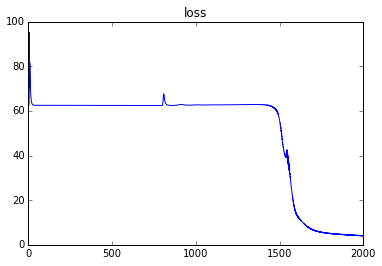

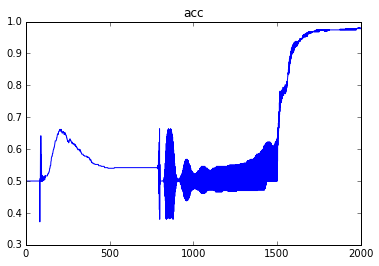

In [38]:
N = X.shape[0]
L_monitor = []
acc_monitor = []
for epoch in range(nb_epochs):
    # forward pass
    e1 = np.dot(X, W1) + b1
    h1 = g(e1)
    e2 = np.dot(h1, W2) + b2
    h2 = g(e2)
    e3 = np.dot(h2, W3) + b3
    o = g(e3)
    acc = ((o[:, 0]>0.5)==y).mean()
    acc_monitor.append(acc)
    print("accuracy : ", acc)
    L = 0.5 * ((y[:, np.newaxis] - o)**2)
    print("loss : ", L.sum())
    L_monitor.append(L.sum())
    # backward pass
    d_o = (o - y[:, np.newaxis])
    d_e3 = d_o * o * (1 - o) # equation 2 + using the property of the sigmoid described just above
    d_h2 = np.dot(d_e3, W3.T) # equation 1
    d_e2 = d_h2 * h2 * (1 - h2) # equation 2 + + using the property of the sigmoid described just above
    d_h1 = np.dot(d_e2, W2.T) # equation 1
    d_e1 = d_h1 * h1 * (1 - h1)
    # gradients
    d_W3 = np.dot(h2.T, d_e3)
    d_W2 = np.dot(h1.T, d_e2)
    d_W1 = np.dot(X.T, d_e1)
    
    d_b3 = d_e3.sum(axis=0)
    d_b2 = d_e2.sum(axis=0)
    d_b1 = d_e1.sum(axis=0)
    # update

    W3 -= alpha * d_W3
    W2 -= alpha * d_W2
    W1 -= alpha * d_W1
    b3 -= alpha * d_b3
    b2 -= alpha * d_b2
    b1 -= alpha * d_b1

plt.plot(L_monitor)
plt.title("loss")
plt.show()
plt.plot(acc_monitor)
plt.title("acc")
plt.show()

In [39]:
class NeuralNet(BaseEstimator):
    
    def predict(self, X):
        e1 = np.dot(X, W1) + b1
        h1 = g(e1)
        e2 = np.dot(h1, W2) + b2
        h2 = g(e2)
        e3 = np.dot(h2, W3) + b3
        o = g(e3)
        y = 1 * (o > 0.5)
        return y[:, 0]

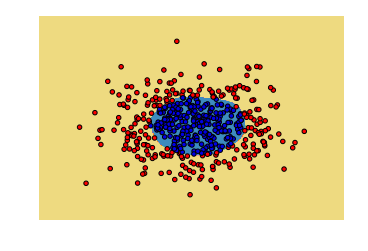

In [40]:
model = NeuralNet()
plot_decision_boundary(model, X, y)

Finally, here we used **squared error** as a loss function for its simplicity but we note that for classification it is rather the [**cross entropy**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) (or logloss) loss function which is used in general along with a [**softmax**](https://en.wikipedia.org/wiki/Softmax_function) activation function in the output layer rather than **sigmoid**. 

The [**softmax**](https://en.wikipedia.org/wiki/Softmax_function) activation function in the output layer converts a set of predictions (one prediction per class) to probabilties, corresponding to a **multinomial distribution**, so it is a generalization of **sigmoid** for multi-class.  

**Cross entropy** penalizes bad predictions more heavily than **squared error**, say for an example the true class is the j-th one and $p_j$ is the predicted probability of the class j (obtained from softmax), then **cross entropy** is for this case : $-log p_j$ which goes to infinity as $p_j$ goes to zero.

# Neural  networks libraries

## Nolearn

Now we will get introduced to one of the neural network libraries and introduce at the same time new concepts.

[**Nolearn**](https://github.com/dnouri/nolearn/) is a high level neural network library, based on [**Lasagne**](https://github.com/Lasagne/Lasagne), which provides a [scikit-learn](scikit-learn.org) like **NeuralNet** class with fit, predict etc. [**Lasagne**](https://github.com/Lasagne/Lasagne) itself is based on [**theano**](https://github.com/Theano/).

[**theano**](https://github.com/Theano/) is not  a library for neural networks only, it is a library which allow you
to manipulate a symbolic computational graph. 

For instance it allows you to write
the loss function as a symbolic variable and then get the gradients with respect to the parameters automatically, after that you can define functions which do some 
computations based on these symbolic variables, like for instance updating the parameters of your model based on the gradients of the loss function with respect to the parameters. These functions are compiled to a fast C code or a CUDA code if you have an NVIDIA GPU card. 

There are a lot of high level libraries for neural networks which uses theano and [**Lasagne**](https://github.com/Lasagne/Lasagne) is one of them. [**Nolearn**](https://github.com/dnouri/nolearn/) provides us a class with a scikit-learn interface based on [**Lasagne**](https://github.com/Lasagne/Lasagne).

In [42]:
import os
os.environ["THEANO_FLAGS"] = "device=gpu" # to tell theano to use a GPU :)
import theano

Let's train  a **feedforward neural network** with **nolearn** for classifying insects !

We start by loading the dataset:

In [43]:
data = np.load("train_64x64.npz")

In [44]:
X, y = data["X"], data["y"]

In [45]:
print(X.shape)
print(y.shape)

(20348, 64, 64, 3)
(20348,)


X are the examples and y the labels.
We see that X is a 4D tensor where :

- the first dimension is the examples
- the second is the height
- the third is the width 
- the fourth (and last) are color channels (RGB).

In [46]:
X = X.astype(np.float32) # For GPUs, theano excpects float32 inputs
X_vectorized = X.reshape((X.shape[0], -1))
print(X_vectorized.shape)

(20348, 12288)


In [47]:
from nolearn.lasagne import NeuralNet, BatchIterator
from lasagne import layers, nonlinearities, updates, init, objectives

In [8]:
net = NeuralNet(
    # Define the architecture here
    layers=[
            ('input', layers.InputLayer), 
            ('hidden1', layers.DenseLayer),
            ('output', layers.DenseLayer),
    ],
    # Layers parameters:
    input_shape=(None, X_vectorized.shape[1]), # Number of input features
    
    hidden1_num_units=100,  # number of units in 1st hidden layer
    hidden1_nonlinearity=nonlinearities.sigmoid,
    hidden1_W=init.Uniform((-0.01, 0.01)),
    
    output_num_units=18,  # 18 classes    
    output_W=init.Uniform((-0.01, 0.01)),
    output_nonlinearity=nonlinearities.softmax,

    # Optimization method:
    update=updates.sgd, # The optimization algorithm is stochastic gradient descent (SGD)
    update_learning_rate=0.1, # The global learning rate of all the weights for SGD
    batch_iterator_train=BatchIterator(batch_size=100), # mini-batch size
    
    use_label_encoder=True, # Converts labels of any kind to integers
    max_epochs=300,  # we want to train this many epochs
    verbose=1, # To monitor training at each epoch
)

In [9]:
net.fit(X_vectorized, y)

# Neural Network with 1230718 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input     12288
  1  hidden1     100
  2  output       18

  epoch    train loss    valid loss    train/val    train_acc    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----------  -----
      1       2.47719       2.49992      0.99091      0.27833      0.28757  0.96s
      2       2.47547       2.49970      0.99030      0.27587      0.28757  0.96s
      3       2.47537       2.49970      0.99027      0.27581      0.28757  0.96s
      4       2.47537       2.49971      0.99026      0.27581      0.28757  0.96s
      5       2.47503       2.49810      0.99076      0.27581      0.28757  0.96s
      6       2.47456       2.49814      0.99056      0.27581      0.28757  0.96s
      7       2.47456       2.49814      0.99056      0.27581      0.28757  0.96s
      8       2.47456       2.49814      0.99056      0.27581      0.28757  0.96s
  

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f4beb480250>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f4beb48f750>,
     custom_score=None,
     hidden1_W=<lasagne.init.Uniform object at 0x7f4beb48f6d0>,
     hidden1_nonlinearity=<function sigmoid at 0x7f4beb855488>,
     hidden1_num_units=100, input_shape=(None, 12288),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden1', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=300, more_params={},
     objective=<function objective at 0x7f4beb4816e0>,
     objective_loss_function=<function categorical_crossentropy at 0x7f4beb811230>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x7f4beb487ab8>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x7f4beb487b00>],
    

Training seems to be slow, we are even not capable of fitting training data. What is the reason behind this slowness ?
First, let's check scaling of the data:

In [10]:
print(X_vectorized.min(), X_vectorized.max())

(0.0, 255.0)


Because input have large values the values of the hidden layer before applying sigmoid have a big magnitude, so the values after applying sigmoid are mostly either close to 0 or close to 1, so they are **saturated**. One way to prevent this is to rescale the inputs to a range which is **compatible** with the range of the activation function, here the sigmoid. 

One way to do that is to force the features to be between the min and the max, for this specific case we can just divide by 255.

In [ ]:
net = NeuralNet(
    # Define the architecture here
    layers=[
            ('input', layers.InputLayer), 
            ('hidden1', layers.DenseLayer),
            ('output', layers.DenseLayer),
    ],
    # Layers parameters:
    input_shape=(None, X_vectorized.shape[1]), # Number of input features
    
    hidden1_num_units=100,  # number of units in 1st hidden layer
    hidden1_nonlinearity=nonlinearities.sigmoid,
    hidden1_W=init.Uniform((-0.01, 0.01)),
    
    output_num_units=18,  # 18 classes    
    output_W=init.Uniform((-0.01, 0.01)),
    output_nonlinearity=nonlinearities.softmax,

    # Optimization method:
    update=updates.sgd, # The optimization algorithm is stochastic gradient descent (SGD)
    update_learning_rate=0.1, # The global learning rate of all the parameters for SGD,
    batch_iterator_train=BatchIterator(batch_size=100), # mini-batch size
    
    use_label_encoder=True, # Converts labels of any kind to integers
    max_epochs=300,  # we want to train this many epochs
    verbose=1, # To monitor training at each epoch
)

In [ ]:
net.fit(X_vectorized/255., y)

You can see the difference between the two. Notice also that in the first case we are **underfitting** and in the second case we are **overfitting**.

There are other ways of preprocessing the data, in (Efficient Backprop, Yann Lecun, 1998), they advice to make the average of each input feature close to zero, to rescale input features to the same scale and make the input features uncorrelated. Making average of each input close to zero and rescaling them to the same scale can be implemetend using [**StandardScaler()**](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) , linear decorrelation can be implemented by a [**PCA**](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

More than that, in (Efficient Backprop, Yann Lecun, 1998), they advice to make the average of each layer to be close to zero, and thus this make classical **sigmoid** not **recommanded** because it is not centered around zero, **tanh** which is a rescaled version of sigmoid, is preferred.

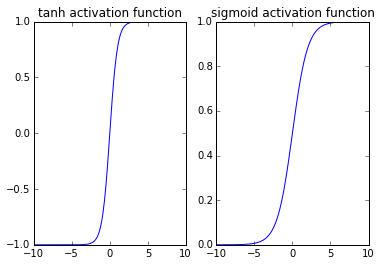

In [48]:
a = np.arange(-10, 10, 0.1)
plt.subplot(1, 2, 1)
plt.plot(a, np.tanh(a))
plt.title("tanh activation function")
plt.subplot(1, 2, 2)
plt.plot(a, 1./(1. + np.exp(-a)))
plt.title("sigmoid activation function")

In [49]:
net = NeuralNet(
    # Define the architecture here
    layers=[
            ('input', layers.InputLayer), 
            ('hidden1', layers.DenseLayer),
            ('output', layers.DenseLayer),
    ],
    # Layers parameters:
    input_shape=(None, X_vectorized.shape[1]), # Number of input features
    
    hidden1_num_units=100,  # number of units in 1st hidden layer
    hidden1_nonlinearity=nonlinearities.tanh,
    hidden1_W=init.Uniform((-0.01, 0.01)),
    
    output_num_units=18,  # 18 classes    
    output_W=init.Uniform((-0.01, 0.01)),
    output_nonlinearity=nonlinearities.softmax,

    # Optimization method:
    update=updates.sgd, # The optimization algorithm is stochastic gradient descent (SGD)
    update_learning_rate=0.1, # The global learning rate of all the parameters for SGD,
    batch_iterator_train=BatchIterator(batch_size=100), # mini-batch size
    
    use_label_encoder=True, # Converts labels of any kind to integers
    max_epochs=30,  # we want to train this many epochs
    verbose=1, # To monitor training at each epoch
)

In [ ]:
from sklearn.preprocessing import StandardScaler

X_vectorized_rescaled = StandardScaler().fit_transform(X_vectorized)
net.fit(X_vectorized_rescaled, y)

You can see how much training is faster now ! 

## Stochastic gradient descent and its variants


The parameter **update** describe the optimization method used, the optimization methods are available in the module **updates** of **lasagne**. 

All of them use the **learning_rate** parameter which you can set by using **update_learning_rate=some_value**, some of them use the **momentum** parameter, which you can set by using **update_momentum=some_value**, some methods have their own additional hyper-parameters. 

For a "live" comparison between some training methods see this link http://cs.stanford.edu/people/karpathy/convnetjs/demo/trainers.html. 

Some methods:

- [**updates.sgd**](http://lasagne.readthedocs.org/en/latest/modules/updates.html#lasagne.updates.sgd) , it is stochastic gradient descent, use only the learning_rate as a global learning rate
- [**updates.momentum**](http://lasagne.readthedocs.org/en/latest/modules/updates.html#lasagne.updates.momentum), use **learning_rate** and **momentum** parameters
- [**updates.nesterov_momentum**](http://lasagne.readthedocs.org/en/latest/modules/updates.html#lasagne.updates.nesterov_momentum) , use **learning_rate** and **momentum** parameters
- [**updates.adagrad**](http://lasagne.readthedocs.org/en/latest/modules/updates.html#lasagne.updates.adagrad) , use only the learning_rate parameter as a global learning rate but is at the same time adaptive and it computes a learning rate for each parameter, learning rate decaying is not needed it is also done automatically.
- [**updates.adadelta**](http://lasagne.readthedocs.org/en/latest/modules/updates.html#lasagne.updates.adadelta), it is based on **adagrad** but proposes to fix some issues that **adadelta** has, the paper states that it is not very sensitive to its hyper-parameters.
- [**updates.adam**](http://lasagne.readthedocs.org/en/latest/modules/updates.html#lasagne.updates.adam)

![](http://i.imgur.com/s25RsOr.gif])

In [ ]:
net = NeuralNet(
    # Define the architecture here
    layers=[
            ('input', layers.InputLayer), 
            ('hidden1', layers.DenseLayer),
            ('output', layers.DenseLayer),
    ],
    # Layers parameters:
    input_shape=(None, X_vectorized.shape[1]), # Number of input features
    
    hidden1_num_units=100,  # number of units in 1st hidden layer
    hidden1_nonlinearity=nonlinearities.tanh,
    hidden1_W=init.Uniform((-0.01, 0.01)),
    
    output_num_units=18,  # 18 classes    
    output_W=init.Uniform((-0.01, 0.01)),
    output_nonlinearity=nonlinearities.softmax,

    # Optimization method:
    update=updates.adadelta, # The optimization algorithm is Adadelta
    batch_iterator_train=BatchIterator(batch_size=100), # mini-batch size
    
    use_label_encoder=True, # Converts labels of any kind to integers
    max_epochs=30,  # we want to train this many epochs
    verbose=1, # To monitor training at each epoch
)

In [ ]:
net.fit(X_vectorized_rescaled, y)

In my experience adadelta/adagrad are good to start with, they are usually behaving well, but as many
authors say, carefeully tuning classical stochastic gradient descent with momentum  works
better in general.

## Activation functions

the activation functions are available in the module **nonlinearities** of **lasagne**.

You can set the activation function for a given layer by **layername_nonlinearity=activation_function**

Complete list : http://lasagne.readthedocs.org/en/latest/modules/nonlinearities.html

- **sigmoid** : not recommanded, except for few cases, it may be useful as output non-linearities for auto-encoders with binary inputs.
- **tanh** : rescaled version of sigmoid which is centered around zero, better than sigmoid.
- **rectify** : Rectified linear units : $max(0, x)$, most widely used right now because they have shown to speed up training and they work well with big models. Their problem is that they are known to "kill" a large number of units (at some some units get always value of zero regardless of inputs, and thus will prevent the weights connected to these units to not be updated).
- **LeakyRectify** : $max(\alpha x, x)$ where $\alpha > 0$ is a hyper-parameter, it is meant to reduce the dead units problem occuring with rectified linear units.
* **leaky_rectify** : **LeakyRectify** with $\alpha=0.01$
* **softmax** : Used in output layers for multi-class classification problems

Note that the default activation function is **rectify**.

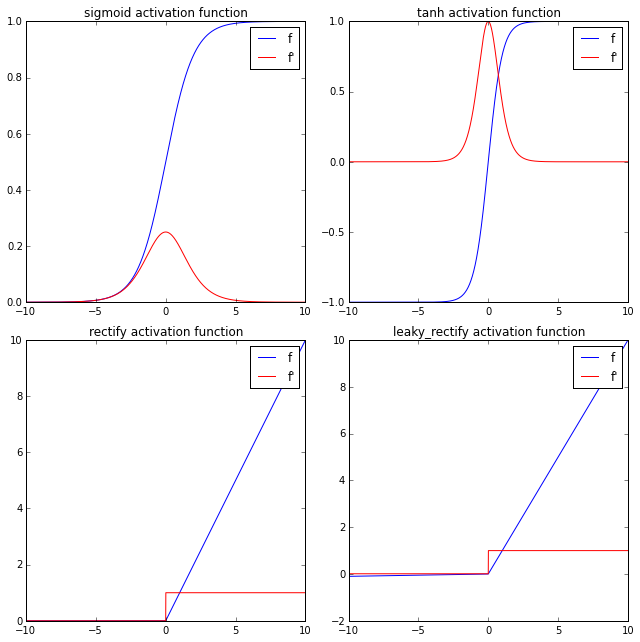

In [50]:
plt.figure(figsize=(9, 9))
a = np.arange(-10, 10, 0.01)
plt.subplot(2, 2, 1)
s = 1./(1 + np.exp(-a))
plt.plot(a, s, color='b', label="f")
plt.plot(a, s * (1 - s), color='r', label="f'")
plt.legend()
plt.title("sigmoid activation function")
plt.subplot(2, 2, 2)
plt.plot(a, np.tanh(a), color='b', label="f")
plt.plot(a, 1 - np.tanh(a)**2, color='r', label="f'")
plt.legend()
plt.title("tanh activation function")
plt.subplot(2, 2, 3)
plt.plot(a, np.maximum(0, a), c='b', label="f")
plt.plot(a, a>0, c='r', label="f'")
plt.legend()
plt.title("rectify activation function")
plt.subplot(2, 2, 4)
plt.plot(a, np.maximum(0.01*a, a), c='b', label="f")
plt.plot(a, (a>0)*1 + (a<0)*0.01, c='r', label="f'")
plt.legend()
plt.title("leaky_rectify activation function")
plt.tight_layout()

You can also implement yymour own activation function, you just create a function which takes an input x and transforms it accordingly, and then you assign this function to **layername_nonlinearity**.

## Weight initialization

Weight initialization is very important as it will determine the behavior of training, with a bad initialization learning will not behave correctly. 

Initialization schemes are available in the model **init** of **lasagne**, they can be set by **layername_W=InitializationProcedureName(params)** for weights and **layername_b=InitializationProcedureName(params)** for biases (default to 0).

Weight initialization should be chosen such that it does not kill the gradients. For instance if we use **tanh** and the input of **tanh** is a linear combination between units in previous layer and weights and there are a lot of units , the scale of the input of the **tanh** will be big, so after applying **tanh** it will be saturated. So one would rescale the weights proportionally to the number of units.

This first kind of initilization is called [**He**](http://lasagne.readthedocs.org/en/latest/modules/init.html#lasagne.init.He), it comes with a uniform [**HeUniform**](http://lasagne.readthedocs.org/en/latest/modules/init.html#lasagne.init.HeUniform) and a normal [**HeNormal**](http://lasagne.readthedocs.org/en/latest/modules/init.html#lasagne.init.HeNormal) version.

The most popular is [**GlorotUniform**](http://lasagne.readthedocs.org/en/latest/modules/init.html#lasagne.init.GlorotUniform) which works
usually well. For a given weight matrix, the proposed range by this scheme is not only based on the number 
of input units but also on the number output units : $$W^{(l)} \sim Unif[-\frac{\sqrt{6}}{-\sqrt{n^{(l)}+n^{(l+1)}}}, \frac{\sqrt{6}}{-\sqrt{n^{(l)}+n^{(l+1)}}}]$$ where $n^{(l)}$ are the number units in layer ${(l)}$. It has also a normal distributed version with the same standard deviation than the uniform distributed version [**GlorotNormal**](http://lasagne.readthedocs.org/en/latest/modules/init.html#lasagne.init.GlorotNormal).

Another scheme worth to try is [**Orthogonal**](http://lasagne.readthedocs.org/en/latest/modules/init.html#lasagne.init.GlorotUniform) initialization, which initializes weight matrices by a random semi-orthogonal matrix.

**Remember** to use **gain='relu'** if you use **rectified linear units** in any of these initialization procedures. 

In [ ]:
net = NeuralNet(
    # Define the architecture here
    layers=[
            ('input', layers.InputLayer), 
            ('hidden1', layers.DenseLayer),
            ('hidden2', layers.DenseLayer),
            ('hidden3', layers.DenseLayer),
            ('output', layers.DenseLayer),
    ],
    # Layers parameters:
    input_shape=(None, X_vectorized.shape[1]), # Number of input features
    
    hidden1_num_units=500,  # number of units in 1st hidden layer
    hidden1_nonlinearity=nonlinearities.rectify,
    hidden1_W=init.GlorotUniform(gain='relu'),
    
    hidden2_num_units=500,  # number of units in 2nd hidden layer
    hidden2_nonlinearity=nonlinearities.rectify,
    hidden2_W=init.GlorotUniform(gain='relu'),
    
    hidden3_num_units=500,  # number of units in 3rd hidden layer
    hidden3_nonlinearity=nonlinearities.rectify,
    hidden3_W=init.GlorotUniform(gain='relu'),

    output_num_units=18,  # 18 classes    
    output_W=init.GlorotUniform(),
    output_nonlinearity=nonlinearities.softmax,

    # Optimization method:
    update=updates.adadelta, # The optimization algorithm is Adadelta
    batch_iterator_train=BatchIterator(batch_size=100), # mini-batch size
    
    use_label_encoder=True, # Converts labels of any kind to integers
    max_epochs=15,  # we want to train this many epochs
    verbose=1, # To monitor training at each epoch
)

In [ ]:
net.fit(X_vectorized_rescaled, y)

## Regularization

So far we have only saw about how to optimize neural networks to fit  training data, so we only dealt with **underfitting** problems occuring with neural networks. But the goal of machine learning is not to fit training data, the goal is to generalize to unseen inputs and thus to have low error on test data. 

As far as we fix the underfitting problem and train our neural network nicely, we can quickly observe overfitting, observed clearly by learning curves :

In [ ]:
train_loss = np.array([i["train_accuracy"] for i in net.train_history_])
valid_loss = np.array([i["valid_accuracy"] for i in net.train_history_])
plt.plot(train_loss, c="b", label="train accuracy", linewidth=3)
plt.plot(valid_loss, c="g", label="valid accuracy", linewidth=3)
plt.legend(loc='best')
plt.show()

The best way to regularize is to get more data ! 

Unfortunately it is not always possible to gather new data 
(specially labeled ones) because it is costly. One way to cheaply gather new data is to exploit some properties
of the data distribution to generate artificially new data. For instance, if we have images, a cheap way to generate
data is to apply affine transformations on the images like **scaling**, **rotations** and 
**translations**. But we will go back to this later.

We will first talk about classical regularization techniques used in neural networks and see how to use them
in **Nolearn**.

### Weight decay

One way to regularize a neural network is to constrain its capacity. Two forms of weight decay penalties are **L1** and **L2**, **L1** penalizes the absolute value of the weights while **L2** penalizes the squared value of the weights. **L1** tends to give sparse values to the weights (that is, exact zero values to a subset of weights).

For both **L1** and **L2** there is a hyper-parameter $\lambda$, called the **regularization coeficient**, it is controlling how much you give importance to regularization compared with fitting the training data (the objective function), it must be a positive real number and it is usually very small, e.g 0.0001.

In [ ]:
from nolearn.lasagne.base import objective
from lasagne.objectives import aggregate
from lasagne.regularization import regularize_layer_params, l2, l1

lambda_regularization = 0.08

def objective_with_L2(layers,
                      loss_function,
                      target,
                      aggregate=aggregate,
                      deterministic=False,
                      get_output_kw=None):
    reg = regularize_layer_params([layers["hidden1"], layers["hidden2"], layers["hidden3"]], l2)
    loss = objective(layers, loss_function, target, aggregate, deterministic, get_output_kw)
    
    if deterministic is False:
        return loss + reg * lambda_regularization
    else:
        return loss

net = NeuralNet(
    # Define the architecture here
    layers=[
            ('input', layers.InputLayer), 
            ('hidden1', layers.DenseLayer),
            ('hidden2', layers.DenseLayer),
            ('hidden3', layers.DenseLayer),
            ('output', layers.DenseLayer),
    ],
    # Layers parameters:
    input_shape=(None, X_vectorized.shape[1]), # Number of input features
    
    hidden1_num_units=500,  # number of units in 1st hidden layer
    hidden1_nonlinearity=nonlinearities.rectify,
    hidden1_W=init.GlorotUniform(gain='relu'),
    
    hidden2_num_units=500,  # number of units in 2nd hidden layer
    hidden2_nonlinearity=nonlinearities.rectify,
    hidden2_W=init.GlorotUniform(gain='relu'),
    
    hidden3_num_units=500,  # number of units in 3rd hidden layer
    hidden3_nonlinearity=nonlinearities.rectify,
    hidden3_W=init.GlorotUniform(gain='relu'),

    output_num_units=18,  # 18 classes    
    output_W=init.GlorotUniform(),
    output_nonlinearity=nonlinearities.softmax,
    
    # objective function
    objective=objective_with_L2,
    # Optimization method:
    update=updates.adadelta, # The optimization algorithm is Adadelta
    batch_iterator_train=BatchIterator(batch_size=100), # mini-batch size
    
    use_label_encoder=True, # Converts labels of any kind to integers
    max_epochs=100,  # we want to train this many epochs
    verbose=1, # To monitor training at each epoch
)

In [ ]:
net.fit(X_vectorized_rescaled, y)

In [ ]:
train_loss = np.array([i["train_accuracy"] for i in net.train_history_])
valid_loss = np.array([i["valid_accuracy"] for i in net.train_history_])
plt.plot(train_loss, c="b", label="train accuracy", linewidth=3)
plt.plot(valid_loss, c="g", label="valid accuracy", linewidth=3)
plt.legend(loc='best')
plt.show()

## Dropout


Another cheap ad simple way to regularize is to use **dropout**. **Dropout** as a way of preventing
units of co-adapting by randomly **dropping** units in each layer, that is setting their values to 0
with a certain probability, with $p=0.5$ usually. 
By applying **dropout**  for a given layer, we force units to be useful as themselves to the next
layer units. **Dropout** can also be seen as a way to create an ensemble of neural networks with
shared parameters. Thus, at test time, to approximate averaging of this ensemble with multiply
the units by **p**.

**Dropout** are a kind of layers in **lasagne**, they take the previous layer, randomly zero-out their
units with the given probability.

In [ ]:
net = NeuralNet(
    # Define the architecture here
    layers=[
            ('input', layers.InputLayer), 
            ('hidden1', layers.DenseLayer),
            ('dropout1', layers.DropoutLayer),
            ('hidden2', layers.DenseLayer),
            ('dropout2', layers.DropoutLayer),
            ('hidden3', layers.DenseLayer),
            ('output', layers.DenseLayer),
    ],
    # Layers parameters:
    input_shape=(None, X_vectorized.shape[1]), # Number of input features
    
    hidden1_num_units=1500,  # number of units in 1st hidden layer
    hidden1_nonlinearity=nonlinearities.rectify,
    hidden1_W=init.GlorotUniform(gain='relu'),
    
    dropout1_p=0.5,
    
    hidden2_num_units=1500,  # number of units in 2nd hidden layer
    hidden2_nonlinearity=nonlinearities.rectify,
    hidden2_W=init.GlorotUniform(gain='relu'),
    
    dropout2_p=0.5,
    
    hidden3_num_units=1500,  # number of units in 3rd hidden layer
    hidden3_nonlinearity=nonlinearities.rectify,
    hidden3_W=init.GlorotUniform(gain='relu'),

    output_num_units=18,  # 18 classes    
    output_W=init.GlorotUniform(),
    output_nonlinearity=nonlinearities.softmax,
    
    # Optimization method:
    update=updates.adadelta, # The optimization algorithm is Adadelta
    batch_iterator_train=BatchIterator(batch_size=100), # mini-batch size
    
    use_label_encoder=True, # Converts labels of any kind to integers
    max_epochs=100,  # we want to train this many epochs
    verbose=1, # To monitor training at each epoch
)

In [ ]:
net.fit(X_vectorized_rescaled, y)

## Early stopping

Another common way of regularizing is to use **early stopping**. As said above, in machine learning we are interested in validation error not in training error so usually we monitor the validation error and stop when it starts increasing. Early stopping is an attempt to automatize this process. It is done by monitoring validation error and memorizing the best model so far in terms of validation error and it stops when the validation error is not decreasing after a certain number epochs determined by a **patience** parameter. The chosen model after stopping is the one with the best error on validation set.

Let's do that in Nolearn

In [ ]:
class EarlyStopping(object):

    def __init__(self, patience=100, criterion='valid_loss',
                 criterion_smaller_is_better=True):
        self.patience = patience
        if criterion_smaller_is_better is True:
            self.best_valid = np.inf
        else:
            self.best_valid = -np.inf
        self.best_valid_epoch = 0
        self.best_weights = None
        self.criterion = criterion
        self.criterion_smaller_is_better = criterion_smaller_is_better

    def __call__(self, nn, train_history):
        current_valid = train_history[-1][self.criterion]
        current_epoch = train_history[-1]['epoch']
        if self.criterion_smaller_is_better:
            cond = current_valid < self.best_valid
        else:
            cond = current_valid > self.best_valid
        if cond:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            if nn.verbose:
                print("Early stopping.")
                print("Best {:s} was {:.6f} at epoch {}.".format(
                    self.criterion, self.best_valid, self.best_valid_epoch))
            nn.load_weights_from(self.best_weights)
            if nn.verbose:
                print("Weights set.")
            raise StopIteration()

    def load_best_weights(self, nn, train_history):
        nn.load_weights_from(self.best_weights)
        
net = NeuralNet(
    # Define the architecture here
    layers=[
            ('input', layers.InputLayer), 
            ('hidden1', layers.DenseLayer),
            ('dropout1', layers.DropoutLayer),
            ('hidden2', layers.DenseLayer),
            ('dropout2', layers.DropoutLayer),
            ('hidden3', layers.DenseLayer),
            ('output', layers.DenseLayer),
    ],
    # Layers parameters:
    input_shape=(None, X_vectorized.shape[1]), # Number of input features
    
    hidden1_num_units=1500,  # number of units in 1st hidden layer
    hidden1_nonlinearity=nonlinearities.rectify,
    hidden1_W=init.GlorotUniform(gain='relu'),
    
    dropout1_p=0.5,
    
    hidden2_num_units=1500,  # number of units in 2nd hidden layer
    hidden2_nonlinearity=nonlinearities.rectify,
    hidden2_W=init.GlorotUniform(gain='relu'),
    
    dropout2_p=0.5,
    
    hidden3_num_units=1500,  # number of units in 3rd hidden layer
    hidden3_nonlinearity=nonlinearities.rectify,
    hidden3_W=init.GlorotUniform(gain='relu'),

    output_num_units=18,  # 18 classes    
    output_W=init.GlorotUniform(),
    output_nonlinearity=nonlinearities.softmax,
    
    # Optimization method:
    update=updates.adadelta, # The optimization algorithm is Adadelta
    batch_iterator_train=BatchIterator(batch_size=100), # mini-batch size
    
    use_label_encoder=True, # Converts labels of any kind to integers
    max_epochs=100,  # we want to train this many epochs
    verbose=1, # To monitor training at each epoch
    
    # handlers
    on_epoch_finished = [EarlyStopping(patience=10, criterion='valid_accuracy', 
                                       criterion_smaller_is_better=False)]
)

In [ ]:
net.fit(X_vectorized_rescaled, y)